# DNN_model.ipynb

In [ ]:
import numpy as np

In [ ]:
def filename_to_index(data):
    names = np.unique(np.array(data['event_type']))
    indices = np.arange(len(names))
    map = dict(zip(names, indices))
    
    return data, map

In [ ]:
def normalize_weights(data):
    N = len(data['event'])
    Ns = sum(data['signal_label'])
    Nb = N-Ns
    sum_wb = sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0)
    sum_ws = sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1)

    #The sum of all weights for both signal and background should be Nb
    array_label = np.array(data['signal_label'])
    array_weight = np.array(data['genWeight'])
    array_weight *= (Nb*(array_label/sum_ws + (1-array_label)/sum_wb))
    data['genWeight'] = array_weight.tolist()
    return data

In [ ]:
data = normalize_weights(data)
print("Total background weight : ", sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0))
print("Total signal weight : ", sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1))
print("Number of background events : ", len(data['event'])-sum(data['signal_label']))

# Test of function "bucketize"

In [ ]:
import os
import fnmatch
from data_extractor import Data_extractor_v1
import pandas as pd
from utils import bucketize

path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/"
channels = os.listdir(path)
data = None
for channel in channels:
    extractor = Data_extractor_v1(channel)
    data = extractor(path+channel+'/anatuple/', data=data)
    print(channel, " done")

In [ ]:
data_processed = pd.DataFrame(data)
print(np.unique(data_processed['channel']))
print(sum(data_processed['channel'] == 'tee'))
print(sum(data_processed['channel'] == 'tem'))
print(sum(data_processed['channel'] == 'tmm'))
print(sum(data_processed['channel'] == 'tte'))
print(sum(data_processed['channel'] == 'ttm'))
data_processed, dictionary = bucketize(data_processed, 'channel')
print(np.unique(data_processed['channel']))
print(sum(data_processed['channel'] == dictionary['tee']))
print(sum(data_processed['channel'] == dictionary['tem']))
print(sum(data_processed['channel'] == dictionary['tmm']))
print(sum(data_processed['channel'] == dictionary['tte']))
print(sum(data_processed['channel'] == dictionary['ttm']))

# feature_importance_analysis.ipynb (before v4)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from TP4b.metrics import fi_perm
from dnn_tau import Dnn_tau
from data_extractor import Data_extractor_v2, output_vars_v2
import os
import fnmatch
from utils import normalize, bucketize, split_dataset
from copy import deepcopy
import pickle
from TP4b.metrics import *

In [ ]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/"
features = deepcopy(output_vars_v2)
features.extend(['signal_label', 'channel', 'event_type', 'mass_hyp'])
channels = os.listdir(path)
relative_path = "/anatuple/"

In [ ]:
values = []
for i in range(len(features)):
    values.append([])
data = dict(zip(features, values))

for channel in channels:
    extractor = Data_extractor_v2(channel)
    data = extractor(path+channel+relative_path, data=data)

In [ ]:
N = len(data['event'])
n_bkg = N-sum([data['signal_label'][i] for i in range(len(data['signal_label']))])
data_norm = normalize(pd.DataFrame(data), 'mass_hyp', n_bkg)
data_norm = normalize(data_norm, 'signal_label', n_bkg)
data_norm = normalize(data_norm, 'channel', n_bkg)
data_processed, channel_indices = bucketize(data_norm, 'channel')
print(list(data_processed.keys()))
print(channel_indices)

In [ ]:
input_vars = ['deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaR_12', 'deltaR_13', 'deltaR_23',
              'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'signal_label', 'channel', 'mass_hyp']

In [ ]:
train, val, test, meas = split_dataset(data_processed)

In [ ]:
extracted_data_path = "extracted_data/TEST9_global_v2_"
train.to_pickle(extracted_data_path+"train")
test.to_pickle(extracted_data_path+"test")
val.to_pickle(extracted_data_path+"val")
meas.to_pickle(extracted_data_path+"meas")

In [ ]:
extracted_data_path = "extracted_data/TEST9_global_v2_"
train = pd.read_pickle(extracted_data_path+"train")
test = pd.read_pickle(extracted_data_path+"test")
val = pd.read_pickle(extracted_data_path+"val")
meas = pd.read_pickle(extracted_data_path+"meas")

input_vars = ['deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaR_12', 'deltaR_13', 'deltaR_23',
              'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'signal_label', 'channel', 'mass_hyp']

x_train = train[input_vars]
x_test = test[input_vars]
x_val = val[input_vars]
x_meas = meas[input_vars]

label_train = x_train.pop('signal_label').astype(float)
label_val = x_val.pop('signal_label').astype(float)
label_test = x_test.pop('signal_label').astype(float)
label_meas = x_meas.pop('signal_label').astype(float)

learning_features = list(x_train.keys())

In [ ]:
depths = [len(learning_features)*2]*5
print(depths)
model = Dnn_tau(list(x_train.keys()), widths=depths)
model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['MSE', 'accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./saved_models/checkpoint",
    monitor = "val_loss",
    save_best_only = True
)
history = model.fit(x_train, label_train, sample_weight=train['genWeight'], validation_data=(x_val, label_val), epochs=100000, verbose=1, 
                    batch_size = 400, callbacks=[early_stopping, checkpoint])
model = tf.keras.models.load_model('./saved_models/checkpoint')
model.save('./saved_models/TEST9_global_v2')
# Save history
filename = "./saved_history/TEST9_global_vs.pkl"
with open(filename, "wb") as file:
    pickle.dump(history.history, file)

In [ ]:
model = tf.keras.models.load_model('./saved_models/TEST9_global_v2')

In [ ]:
print(model.metrics_names)

In [ ]:
delta_loss_perm = []
loss_no_shuffle = fi_perm(model, test, input_vars, [])
for key in learning_features:
    loss_shuffle = fi_perm(model, test, input_vars, key)
    delta_loss_perm.append(loss_shuffle-loss_no_shuffle)
delta_loss_perm = dict(zip(learning_features, delta_loss_perm))
print(delta_loss_perm)

In [ ]:
filename = "./saved_results/TEST9_global_v1_loss_shuffle.pkl"
with open(filename, "wb") as file:
    pickle.dump(delta_loss_perm, file)

In [ ]:
filename = "./saved_results/TEST9_global_v1_loss_shuffle.pkl"
with open(filename, "rb") as f:
    delta_loss_perm = pickle.load(f)

In [ ]:
for key in delta_loss_perm:
    print(key, "  \t: {:.5f}".format(delta_loss_perm[key]))

In [ ]:
from TP4b.metrics import fi_mutual_info
mis = fi_mutual_info(model, test, input_vars)

# Test of poisson significance estimator with one variable

In [1]:
from metrics import poisson_significance
import pandas as pd
from utils import plot_hist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle('extracted_data/TEST9_global_v4_all_normalized')
scores = df['HNL_CM_mass_1']
signal_label = df['signal_label']
weights = df['genWeight']
bins = np.linspace(0,400,200)

sig, bins = poisson_significance(scores, signal_label, weights, bins)

100%|██████████| 200/200 [00:03<00:00, 50.19it/s]


In [3]:
thresh = bins[np.argmax(sig)]

In [4]:
print(len(bins))
print(len(sig))

200
200


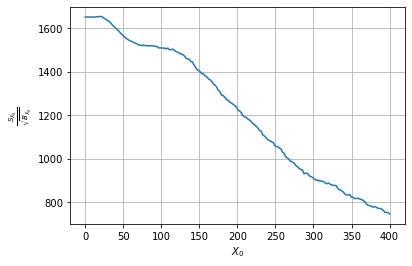

In [5]:
plt.plot(bins, sig)
plt.xlabel('$X_0$')
plt.ylabel(r'$\frac{S_{X_0}}{\sqrt{B_{X_0}}}$')
plt.grid()

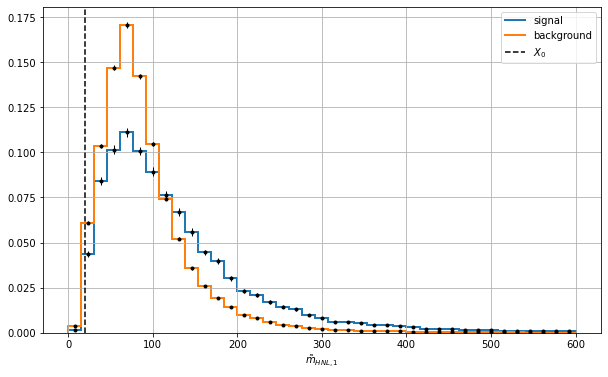

In [6]:
import numpy as np
bins = np.linspace(0,600, 40)
fig = plot_hist(df, 'HNL_CM_mass_1', r'$\tilde{m}_{HNL,1}$', bins, mode='simple_signal_label', return_counts=True)
ax = fig[0].axes[0]
y_min, y_max = ax.get_ylim()
ax.axvline(thresh, color='k', linestyle='--', label='$X_0$')
ax.legend()